Trabalhado final, feito em dupla, para a disciplina de Aprendizado de Máquina


O problema que escolhemos tratar é a **Classificação de Músicas pelo Gênero Musical**.

# Baixando Dataset

Foi utilizado um dataset do *kaggle* que conta com uma coleção de 1000 músicas (trechos de 30s), divididas em 10 gêneros musicais diferentes (100 músicas de cada gênero): **Jazz**, **Classical**, **Blues**, **Reggae**, **Hiphop**, **Country**, **Disco**, **Rock**, **Metal** e **Pop**.

O dataset possui os arquivos de som no formato *.wav*, espectrogramas no formato *.png* e ainda alguns arquivos *.csv* com atributos extraídos dos dados. Dentre esses, escolhemos trabalhar apenas com os espectrogramas. De acordo com os autores do dataset, os espectrogramas foram gerados com o método *librosa.feature.melspectrogram*, utilizando os parâmetros default definidos no próprio site *librosa.org*

Link: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

In [ ]:
# Key para o kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eduardolmsantosjr","key":"05388d88bcd36205f34388172efeceb3"}'}

In [ ]:
! pip install -q kaggle

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:10<00:00, 160MB/s]
100% 1.21G/1.21G [00:10<00:00, 127MB/s]


In [ ]:
!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

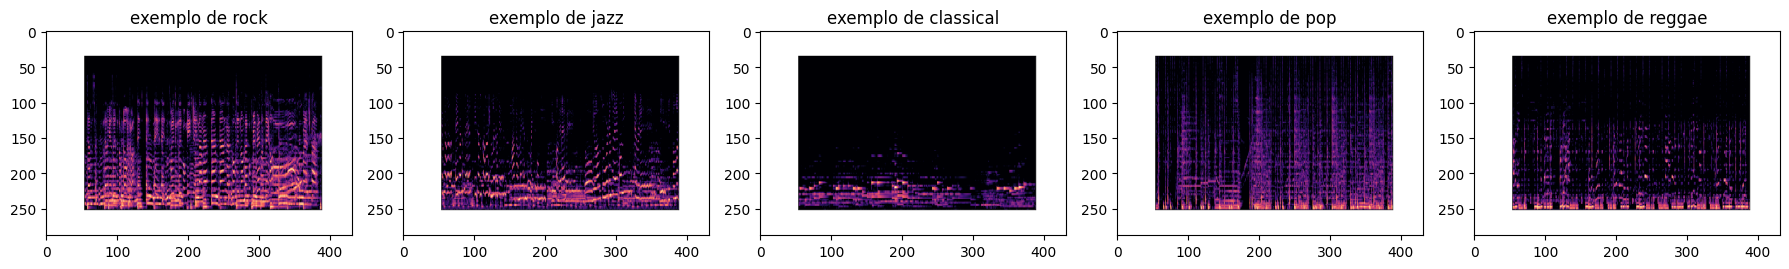

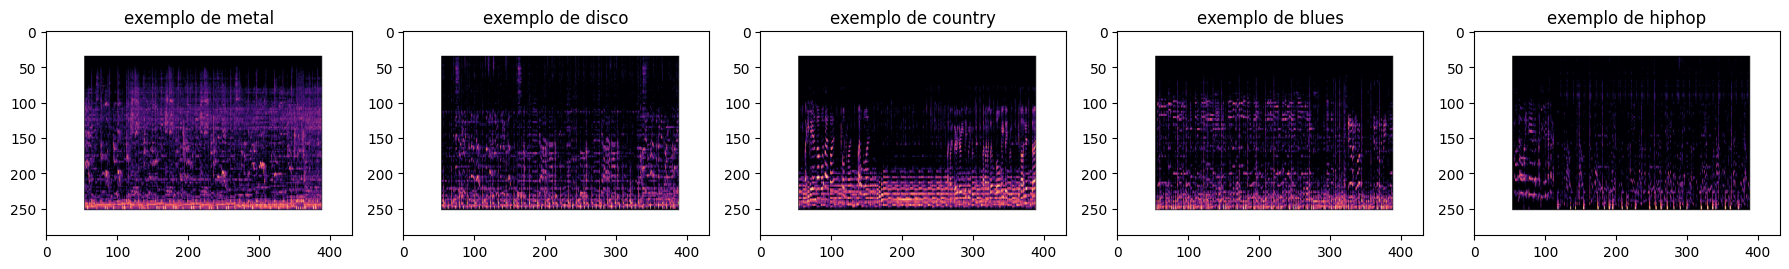

In [ ]:
import matplotlib.pyplot as plt

dataset = 'Data/images_original/'
exemplos = []
pastas = listdir(dataset)
for pasta in pastas:
  caminho = dataset + pasta + '/'
  exemplos.append(caminho + listdir(caminho)[0])

plt.figure(figsize=(18, 18))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(plt.imread(exemplos[i]))
  plt.title("exemplo de " + exemplos[i].split('/')[2])
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 18))
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(plt.imread(exemplos[i+5]))
  plt.title("exemplo de " + exemplos[i+5].split('/')[2])
plt.tight_layout()
plt.show()

# Gerando treino e teste

Para separar a base de dados em treino e teste, utilizamos a biblioteca *sklearn*, e dividimos com uma razão de 70% e 30%, respectivamente.

Optamos também por criar pastas dividindo as imagens entre treino e teste, para manter a mesma divisão em todos os métodos que serão testados.

In [ ]:
from os import listdir
from os.path import isfile, join

dataset = 'Data/images_original/'
imagens = []
pastas = listdir(dataset)
for pasta in pastas:
  caminho = dataset + pasta + '/'
  imagens += [f for f in listdir(caminho) if isfile(join(caminho, f)) and '.png' in f]  # Guarda os paths de todas as imagens no vetor

In [ ]:
import shutil

def remove_folder(path):
    if os.path.exists(path):
         shutil.rmtree(path)

In [ ]:
from sklearn.model_selection import train_test_split
from shutil import copyfile
import os

remove_folder('dados/train')  # Remove as pastas caso já existam, para o caso de rodarmos mais de uma vez
remove_folder('dados/test')   # a geração de treino e teste sem reiniciar o ambiente de execução

x_train ,x_test = train_test_split(imagens, test_size=0.3)  # Divide a base de dados
train_balance = []
test_balance = []

for img in x_train:
  img_class = img.split('0')[0]
  train_balance.append(img_class)

  if not os.path.exists('dados/train/'+img_class):
      os.makedirs('dados/train/'+img_class)

  copyfile(dataset+img_class+'/'+img, 'dados/train/'+img_class+'/'+img) # Copia a imagem para a pasta correta criada

for img in x_test:
  img_class = img.split('0')[0]
  test_balance.append(img_class)

  if not os.path.exists('dados/test/'+img_class):
      os.makedirs('dados/test/'+img_class)

  copyfile(dataset+img_class+'/'+img, 'dados/test/'+img_class+'/'+img)  # Copia a imagem para a pasta correta criada

Após gerarmos as pastas com as imagens de treino e teste, nós plotamos os histogramas do número de imagens por classe nos grupos de treino e teste, para checar se estavam balanceados.

Text(0.5, 1.0, 'Teste')

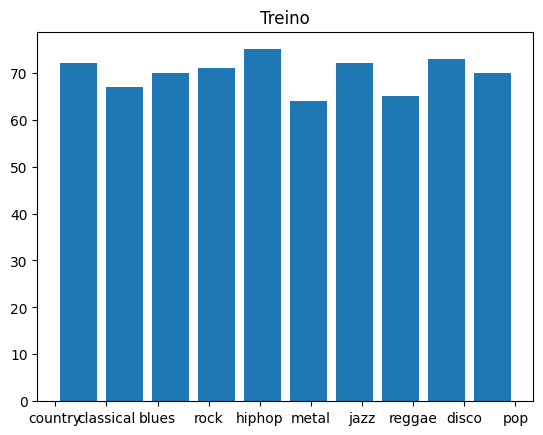

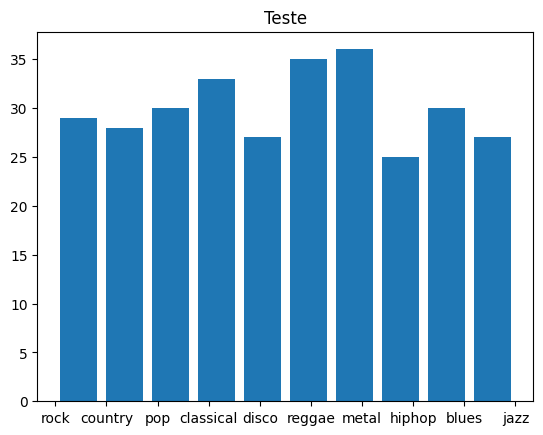

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(train_balance, rwidth=.8)
plt.title("Treino")
plt.figure()
plt.hist(test_balance, rwidth=.8)
plt.title("Teste")

# Baseline

Para a Baseline de comparação, utilizamos um modelo passado pelo professor.

Como nosso objetivo principal com o trabalho era criar nossa própria rede neural e compará-la com a Baseline passada, optamos por não mudar muitos aspectos da forma como a estratégia da Baseline estava implementada. Por exemplo, não alteramos o tratamento dos dados nem os parâmetros do treinamento.

In [ ]:
!pip install ktrain

In [ ]:
import ktrain
from ktrain import vision as vis
from sklearn.metrics import classification_report

## Tratando os Dados

Na verdade não foi utilizado nenhum tipo de tratamento de dados na Baseline, as imagens apenas foram extraídas das pastas no mesmo formato em que estavam.

In [ ]:
(train_data, val_data, preproc) = vis.images_from_folder('dados/')

color_mode detected (rgby) different than color_mode selected (rgb)
Found 699 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


## Criando o Modelo

O modelo utilizado foi o *resnet50*, um modelo de rede neural convolucional pré-treinado de 50 camadas.

In [ ]:
vis.print_image_classifiers()

pretrained_resnet50: 50-layer Residual Network (pretrained on ImageNet)
resnet50: 50-layer Resididual Network (randomly initialized) [https://arxiv.org/abs/1512.03385]
pretrained_mobilenet: MobileNet Neural Network (pretrained on ImageNet)
mobilenet: MobileNet Neural Network (randomly initialized) [https://arxiv.org/abs/1704.04861]
pretrained_mobilenetv3: MobileNetV3-Small Neural Network (pretrained on ImageNet)
mobilenetv3: MobileNetV3-Small Neural Network (randomly initialized) [https://arxiv.org/abs/1905.02244]
pretrained_inception: Inception Version 3  (pretrained on ImageNet)
inception: Inception Version 3 (randomly initialized) [http://arxiv.org/abs/1512.00567]
pretrained_efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet)
efficientnetb1: EfficientNet-B1 Neural Network (pretrained on ImageNet) [https://arxiv.org/abs/1905.11946]
pretrained_efficientnetb7: EfficientNet-B7 Neural Network (pretrained on ImageNet)
efficientnetb7: EfficientNet-B7 Neural Network (pre

In [ ]:
model_base = vis.image_classifier('pretrained_resnet50', train_data, val_data)

The normalization scheme has been changed for use with a pretrained_resnet50 model. If you decide to use a different model, please reload your dataset with a ktrain.vision.data.images_from* function.

Is Multi-Label? False
Is Regression? False
pretrained_resnet50 model created.


## Treinando o Modelo

O modelo foi treinado por apenas 5 épocas, com um learning rate de 0,0001 e um batch size de 64.

In [ ]:
learner = ktrain.get_learner(model=model_base, train_data=train_data, val_data=val_data,
                             workers=8, use_multiprocessing=False, batch_size=64)

In [ ]:
learner.fit_onecycle(1e-4, 5)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/5
11/11 [==============================] - 20s 1s/step - loss: 4.2999 - accuracy: 0.1559 - val_loss: 2.3207 - val_accuracy: 0.3167
Epoch 2/5
11/11 [==============================] - 17s 1s/step - loss: 3.0035 - accuracy: 0.3133 - val_loss: 1.5823 - val_accuracy: 0.5000
Epoch 3/5
11/11 [==============================] - 12s 759ms/step - loss: 2.1780 - accuracy: 0.4692 - val_loss: 1.4020 - val_accuracy: 0.5733
Epoch 4/5
11/11 [==============================] - 11s 739ms/step - loss: 1.5634 - accuracy: 0.5808 - val_loss: 1.2168 - val_accuracy: 0.6433
Epoch 5/5
11/11 [==============================] - 12s 911ms/step - loss: 1.2807 - accuracy: 0.6395 - val_loss: 1.1956 - val_accuracy: 0.6667


## Testando o Modelo

Para checar o quão bem a Baseline aprendeu a tarefa, utilizamos ela para prever o grupo de teste, e geramos o Classification Report.

Podemos ver que o Score F1 Macro é por volta de 0,6.

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [ ]:
pred=[]
ref=[]
pastas = os.listdir("/content/dados/test/")
for pasta in pastas:
  for imagem in os.listdir("/content/dados/test/"+pasta+'/'):
    ref.append(pasta)
    pred+=predictor.predict_filename("/content/dados/test/"+pasta+'/'+imagem)

In [ ]:
print(classification_report(ref,pred))

              precision    recall  f1-score   support

       blues       0.48      0.70      0.57        30
   classical       0.94      0.97      0.96        33
     country       0.40      0.68      0.51        28
       disco       0.42      0.56      0.48        27
      hiphop       1.00      0.68      0.81        25
        jazz       0.92      0.44      0.60        27
       metal       1.00      0.75      0.86        36
         pop       0.38      0.70      0.49        30
      reggae       0.61      0.40      0.48        35
        rock       1.00      0.10      0.19        29

    accuracy                           0.60       300
   macro avg       0.71      0.60      0.59       300
weighted avg       0.72      0.60      0.60       300



# Nossas soluções

Utilizamos 3 estratégias diferentes nas redes neurais para tentar obter o melhor resultado possível:
- Rede MultiLayer Perceptron (MLP)
- Rede Convolucional (CNN)
- Rede Convolucional com utilização de um Autoencoder (CNN+Autoencoder)

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import cv2 as cv
import keras.backend as K
from sklearn.metrics import f1_score
import gc

##Tratando os Dados

Para melhorar a convergência das redes construídas, realizamos alguns tratamentos nos dados:
- Retiramos uma borda branca que estava presente em todas as imagens;
- Reduzimos a quantidade de canais, convertendo as imagens para escala de cinza.

In [ ]:
train_dados=[]
labels_train=[]
for i in os.listdir('/content/dados/train/'):
  for j in os.listdir('/content/dados/train/'+i):
    img = cv.imread('/content/dados/train/'+i+'/'+j)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    cropped_gray = gray[35:253, 54:390]
    train_dados.append(np.reshape(cropped_gray, (*cropped_gray.shape, 1)))
    labels_train.append(i)

test_dados=[]
labels_test=[]
for i in os.listdir('/content/dados/test/'):
  for j in  os.listdir('/content/dados/test/'+i):
    img = cv.imread('/content/dados/test/'+i+'/'+j)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    cropped_gray = gray[35:253, 54:390]
    test_dados.append(np.reshape(cropped_gray, (*cropped_gray.shape, 1)))
    labels_test.append(i)

A seguir, pode-se verificar as alterações feitas na imagem:

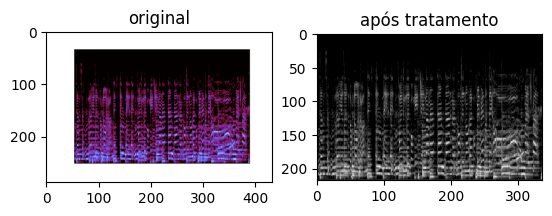

In [ ]:
genre = os.listdir('/content/dados/train/')[0]
img = cv.imread('/content/dados/train/' + genre + '/' + os.listdir('/content/dados/train/'+genre)[0])
img_treated = train_dados[0]

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original")
plt.subplot(1,2,2)
plt.imshow(img_treated, cmap="gray")
plt.title("após tratamento")
plt.show()

Criamos também um encoder, cuja única função é transformar os valores de classe (gênero musical) das strings ("pop", "rock", etc) para os valores int de 0 a 9 respectivos, e vice-versa.

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(labels_train)

LabelEncoder()

##MLP

### Criando o Modelo

A rede MLP construída é bem simples, consistindo apenas de camadas densas, variando a quantidade de neurônios por camada.

Para poder utilizar a MLP com uma imagem, inicialmente essa imagem é "achatada", para tratarmos os valores dos pixels como atributos.

In [ ]:
model_mlp = models.Sequential()
model_mlp.add(layers.Flatten(input_shape=train_dados[0].shape))
model_mlp.add(layers.Dense(200, activation='relu'))
model_mlp.add(layers.Dense(160, activation='relu'))
model_mlp.add(layers.Dense(120, activation='relu'))
model_mlp.add(layers.Dense(100, activation='relu'))
model_mlp.add(layers.Dense(100, activation='relu'))
model_mlp.add(layers.Dense(40, activation='relu'))
model_mlp.add(layers.Dense(20, activation='relu'))
model_mlp.add(layers.Dense(10, activation='softmax'))

O otimizador para o ajuste dos pesos da rede é o Adam (Adaptive Moment Estimation), o qual faz uso do conceito de momento. De forma simplificada, ele busca introduzir uma inércia durante o processo de descida de gradiente, de modo a evitar paradas repentinas da atualização dos valores, evitando o que pode ser um ponto de mínimo local para o valor de perda. A inércia nesse algoritmo é com respeito às médias móveis dos gradientes e dos quadrados dos gradientes.

Esse otimizador também apresenta hiperparâmetros de decaimento para o peso dessas inércias, permitindo a convergência do modelo para um mínimo.

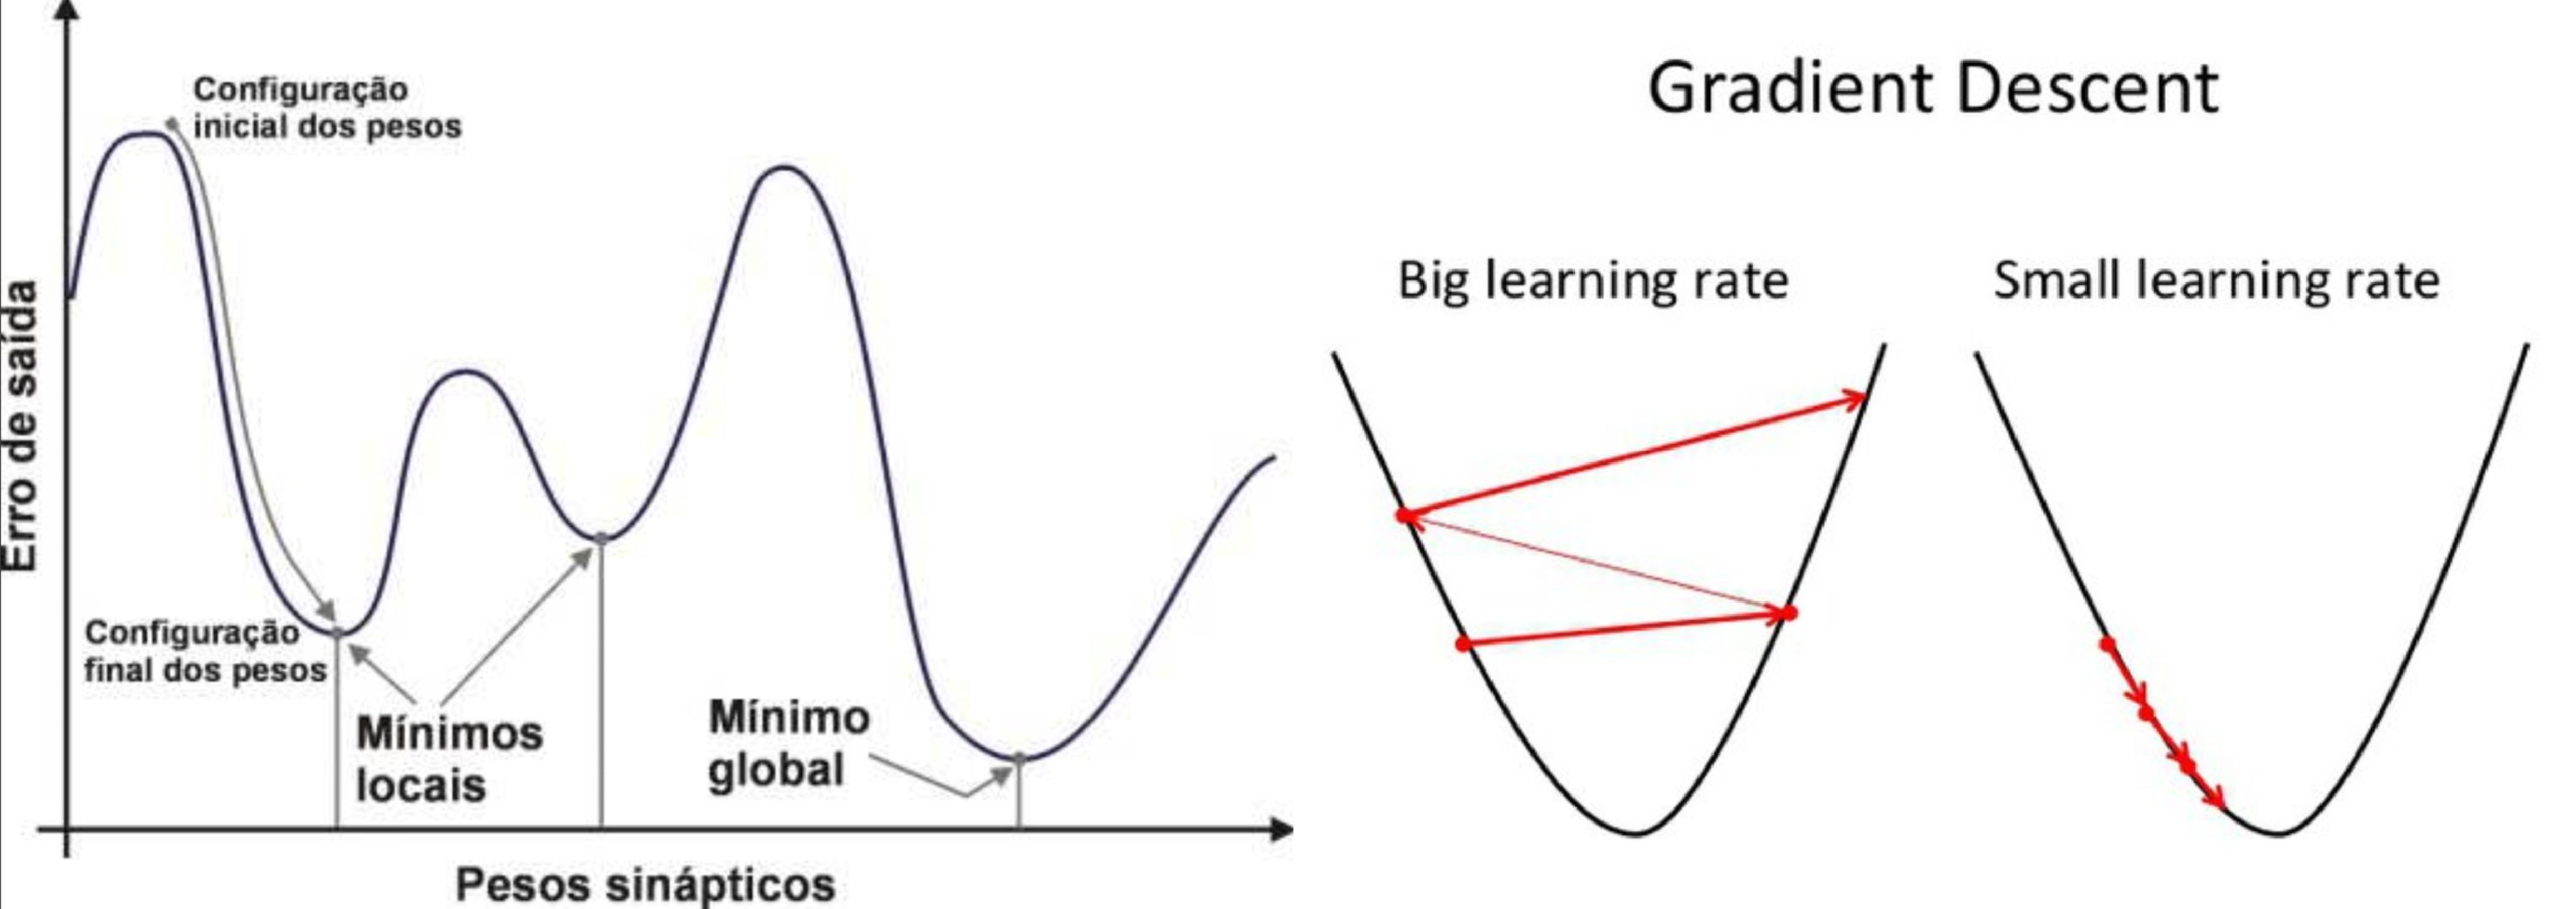

A função de perda utilizada é a entropia cruzada. O método *SparseCategoricalCrossentropy* recebe uma saída no formato de *softmax* e compara com as classes em um vetor de inteiros.

In [ ]:
model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Utilizamos o mesmo otimizador e a mesma função de perda para todos os modelos construídos.

In [ ]:
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 73248)             0         
                                                                 
 dense (Dense)               (None, 200)               14649800  
                                                                 
 dense_1 (Dense)             (None, 160)               32160     
                                                                 
 dense_2 (Dense)             (None, 120)               19320     
                                                                 
 dense_3 (Dense)             (None, 100)               12100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 40)               

### Treinando o Modelo

O modelo foi treinado por 30 épocas, com um learning rate de 0,00005 e um batch size de 64.

In [ ]:
ep = np.arange(5,30+1,5)
score_mlp=[]

for i in ep:
  model_mlp.fit(np.array(train_dados),encoder.transform(labels_train), epochs=5, batch_size=64)
  score_mlp.append(f1_score(labels_test, encoder.inverse_transform(np.argmax(model_mlp.predict(np.array(test_dados)),axis=1)), average='macro'))

gc.collect()

Epoch 1/5
11/11 [==============================] - 3s 10ms/step - loss: 10.5064 - accuracy: 0.1016
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 5.7335 - accuracy: 0.1731
Epoch 3/5
11/11 [==============================] - 0s 10ms/step - loss: 3.9665 - accuracy: 0.2532
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 2.9671 - accuracy: 0.2947
Epoch 5/5
10/10 [==============================] - 0s 3ms/step
Epoch 1/5
11/11 [==============================] - 0s 9ms/step - loss: 1.6188 - accuracy: 0.5079
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 1.1684 - accuracy: 0.6567
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.9220 - accuracy: 0.7511
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.7468 - accuracy: 0.8069
Epoch 5/5
10/10 [==============================] - 0s 3ms/step
Epoch 1/5
11/11 [==============================] - 0s 9ms/step - loss: 0.5362 - accuracy: 0.87

8772

Plotamos a variação do F1 Score macro ao longo das épocas, para facilitar a análise de convergência (se ocorreu um *overfit* ou se ainda podemos aumentar as épocas).

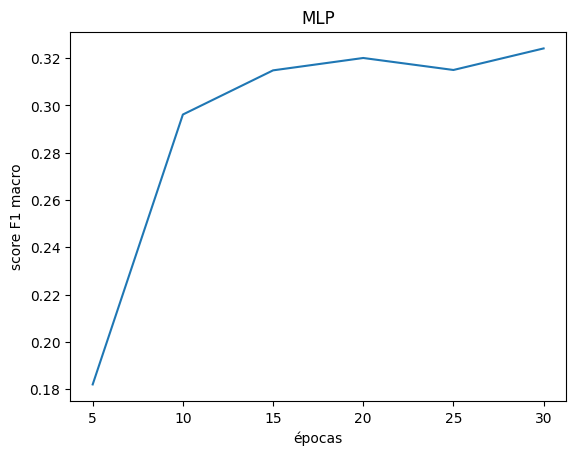

In [ ]:
plt.plot(ep, score_mlp)
plt.xlabel("épocas")
plt.ylabel("score F1 macro")
plt.title("MLP")
plt.show()

Realizamos esse mesmo plot para o treinamento de todos os modelos construídos.

### Testando o Modelo

Para checar o quão bem a MLP aprendeu a tarefa, utilizamos ela para prever o grupo de teste, e geramos o Classification Report.

Podemos ver que o Score F1 Macro é por volta de 0,35.

In [ ]:
pred_mlp = model_mlp.predict(np.array(test_dados))

10/10 [==============================] - 0s 4ms/step


In [ ]:
print(classification_report(labels_test,encoder.inverse_transform(np.argmax(pred_mlp,axis=1))))

              precision    recall  f1-score   support

       blues       0.30      0.23      0.26        30
   classical       0.51      0.61      0.56        33
     country       0.19      0.18      0.19        28
       disco       0.11      0.15      0.12        27
      hiphop       0.31      0.44      0.37        25
        jazz       0.56      0.33      0.42        27
       metal       0.57      0.64      0.61        36
         pop       0.55      0.37      0.44        30
      reggae       0.00      0.00      0.00        35
        rock       0.21      0.45      0.28        29

    accuracy                           0.34       300
   macro avg       0.33      0.34      0.32       300
weighted avg       0.34      0.34      0.33       300



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##CNN

###Criando o Modelo

Para a criação da CNN, foram testadas diversas combinações de camadas convolucionais com diferentes tamanhos de filtro e quantidade de neurônios.

A arquitetura consiste da repetição de duas camadas convolucionais, uma camada de *pooling* e uma camada para *dropout*.

O *dropout* consiste de desligar aleatoriamente a conexão entre neurônios entre camadas, trazendo algumas vantagens:
- Menor dependência entre as camadas;
- Redução do *overfitting*;
- Redução do desaparecimento de gradiente durante o treinamento;
- Treinamento mais eficiente.

Por fim, são adicionadas camadas densas, finalizadas em uma camada ativada por *softmax*, de tal modo que cada neurônio representa uma classe.

In [ ]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (15, 15), activation='relu', padding='same', input_shape=train_dados[0].shape))
model_cnn.add(layers.Conv2D(32, (10, 10), activation='relu', padding='same'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Conv2D(32, (10, 10), activation='relu', padding='same'))
model_cnn.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model_cnn.add(layers.AvgPool2D((2, 2)))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same'))
model_cnn.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn.add(layers.Conv2D(32, (2, 2), activation='relu', padding='same'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(32, activation='relu'))
model_cnn.add(layers.Dense(32, activation='relu'))
model_cnn.add(layers.Dense(10))
model_cnn.add(layers.Softmax())

In [ ]:
model_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 218, 336, 32)      7232      
                                                                 
 conv2d_12 (Conv2D)          (None, 218, 336, 32)      102432    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 109, 168, 32)     0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 109, 168, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 168, 32)      102432    
                                                                 
 conv2d_14 (Conv2D)          (None, 109, 168, 32)      25632     
                                                      

###Treinando o Modelo

O modelo foi treinado por 20 épocas, com um learning rate de 0,001 e um batch size de 64.

In [ ]:
ep = np.arange(5,20+1,5)
score=[]

for i in ep:
  model_cnn.fit(np.array(train_dados),encoder.transform(labels_train), epochs=5, batch_size=64)
  score.append(f1_score(labels_test, encoder.inverse_transform(np.argmax(model_cnn.predict(np.array(test_dados)),axis=1)), average='macro'))

gc.collect()

Epoch 1/5
11/11 [==============================] - 13s 793ms/step - loss: 3.8688 - accuracy: 0.0987
Epoch 2/5
11/11 [==============================] - 9s 789ms/step - loss: 2.3026 - accuracy: 0.0959
Epoch 3/5
11/11 [==============================] - 9s 789ms/step - loss: 2.3023 - accuracy: 0.1130
Epoch 4/5
11/11 [==============================] - 9s 785ms/step - loss: 2.2984 - accuracy: 0.1245
Epoch 5/5
10/10 [==============================] - 1s 62ms/step
Epoch 1/5
11/11 [==============================] - 9s 773ms/step - loss: 2.2955 - accuracy: 0.1073
Epoch 2/5
11/11 [==============================] - 8s 768ms/step - loss: 2.2509 - accuracy: 0.1845
Epoch 3/5
11/11 [==============================] - 8s 767ms/step - loss: 2.1970 - accuracy: 0.1917
Epoch 4/5
11/11 [==============================] - 8s 766ms/step - loss: 2.1509 - accuracy: 0.1874
Epoch 5/5
10/10 [==============================] - 1s 62ms/step
Epoch 1/5
11/11 [==============================] - 8s 769ms/step - loss: 2.1233

8850

Text(0.5, 1.0, 'CNN')

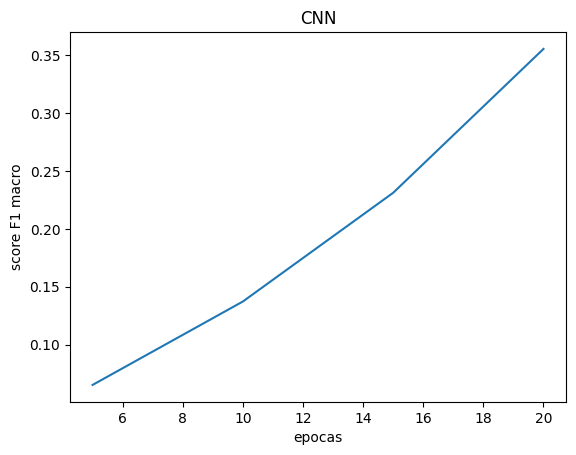

In [ ]:
plt.plot(ep,score)
plt.xlabel("epocas")
plt.ylabel("score F1 macro")
plt.title("CNN")

###Testando o Modelo

Para checar o quão bem a CNN aprendeu a tarefa, utilizamos ela para prever o grupo de teste, e geramos o Classification Report.

Podemos ver que o Score F1 Macro é por volta de 0,4.

In [ ]:
pred_cnn = model_cnn.predict(np.array(test_dados))

10/10 [==============================] - 1s 61ms/step


In [ ]:
print(classification_report(labels_test,encoder.inverse_transform(np.argmax(pred_cnn,axis=1))))

              precision    recall  f1-score   support

       blues       0.33      0.03      0.06        30
   classical       0.77      0.52      0.62        33
     country       0.38      0.11      0.17        28
       disco       0.27      0.74      0.39        27
      hiphop       0.40      0.08      0.13        25
        jazz       0.33      0.59      0.42        27
       metal       0.68      0.72      0.70        36
         pop       0.43      0.70      0.53        30
      reggae       0.39      0.34      0.36        35
        rock       0.20      0.14      0.16        29

    accuracy                           0.41       300
   macro avg       0.42      0.40      0.36       300
weighted avg       0.43      0.41      0.37       300



##CNN + Autoencoder

### Autoencoder

O autoencoder é uma rede feita para reconstrução da própria entrada, mas com a redução da dimensionalidade desta ao longo de si. Desta forma, espera-se que, na porção interna da rede, sejam gerados mapas de ativação que extraíram as características mais importantes dessa entrada.

O modelo é dividido em *encoder*, o qual diminui a dimensionalidade e extrai características, e *decoder*, que reconstrói a entrada a partir do que foi gerado anteriormente.

In [ ]:
K.clear_session()

autoencoder = models.Sequential()
# Encoder
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=train_dados[0].shape))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((2, 2), padding='same'))

# Decoder
autoencoder.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.UpSampling2D((2, 2)))
autoencoder.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
autoencoder.add(layers.UpSampling2D((2, 2)))
autoencoder.add(layers.Conv2D(16, (3, 3), activation='relu',padding='same'))
autoencoder.add(layers.UpSampling2D((2, 2)))
autoencoder.add(layers.Conv2D(16,(7,1),activation='relu'))
autoencoder.add(layers.Conv2D(1, (3, 3), activation='relu', padding='same'))

Nesse caso, como trata-se de um problema de regressão, a *loss* utilizada foi o *MeanSquaredError*.

In [ ]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 336, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 168, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 168, 16)      2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 168, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 84, 8)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 55, 84, 8)         5

Treinamos a rede autoencoder por 70 épocas e um batch size de 64.

In [ ]:
autoencoder.fit(np.array(train_dados),np.array(train_dados), epochs=70, batch_size=64)

Epoch 1/70
11/11 [==============================] - 6s 173ms/step - loss: 1981.3762
Epoch 2/70
11/11 [==============================] - 2s 168ms/step - loss: 1520.3281
Epoch 3/70
11/11 [==============================] - 2s 165ms/step - loss: 838.5522
Epoch 4/70
11/11 [==============================] - 2s 165ms/step - loss: 726.1814
Epoch 5/70
11/11 [==============================] - 2s 166ms/step - loss: 678.2537
Epoch 6/70
11/11 [==============================] - 2s 167ms/step - loss: 644.8224
Epoch 7/70
11/11 [==============================] - 2s 167ms/step - loss: 623.4407
Epoch 8/70
11/11 [==============================] - 2s 168ms/step - loss: 607.2209
Epoch 9/70
11/11 [==============================] - 2s 172ms/step - loss: 591.8505
Epoch 10/70
11/11 [==============================] - 2s 171ms/step - loss: 578.4195
Epoch 11/70
11/11 [==============================] - 2s 170ms/step - loss: 567.4868
Epoch 12/70
11/11 [==============================] - 2s 169ms/step - loss: 559.0308

Após o treino, extraimos somente a parcela de encoder.

In [ ]:
from keras.models import Model

# Criar o modelo até a camada de encoder
enc = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('max_pooling2d_2').output)

# Visualizar o resumo do modelo do encoder
enc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 218, 336, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 218, 336, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 168, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 168, 16)      2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 168, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 84, 8)        0         
 2D)                                                         

Analisando o obtido com a rede, temos a imagem reconstruída:

1/1 [==============================] - 0s 308ms/step


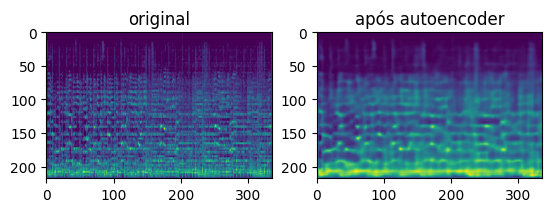

In [ ]:
img = np.array(train_dados)[10]
img_transf = autoencoder.predict(img.reshape(1,218,336,1))

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original")
plt.subplot(1,2,2)
plt.imshow(img_transf[0])
plt.title("após autoencoder")
plt.show()

Podemos verificar também os mapas de ativação do encoder:

1/1 [==============================] - 0s 76ms/step


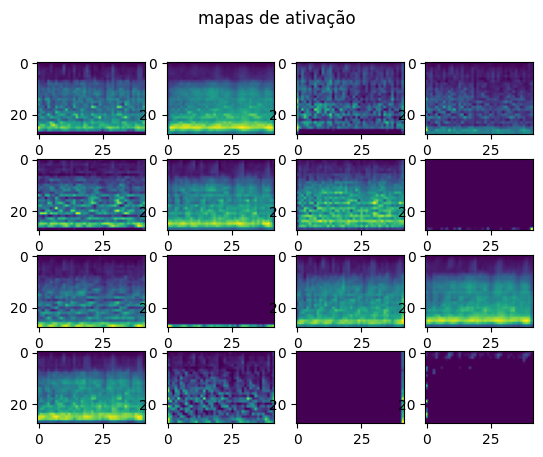

In [ ]:
img_transf2 = enc.predict(img.reshape(1,218,336,1))

for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(img_transf2[:,:,:,i].reshape(28,42))
plt.suptitle("mapas de ativação")
plt.show()

### Criando o Modelo

Foi criado um modelo semelhante à CNN apresentada anteriormente, mas sem a utilização de *pooling*, porque a dimensão da imagem já é reduzida pelo encoder.

In [ ]:
model_cnn_ae = models.Sequential()
model_cnn_ae.add(layers.Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=(28,42,16)))
model_cnn_ae.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn_ae.add(layers.Dropout(0.5))
model_cnn_ae.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn_ae.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model_cnn_ae.add(layers.Dropout(0.5))
model_cnn_ae.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model_cnn_ae.add(layers.Conv2D(32, (10, 10), activation='relu', padding='same'))
model_cnn_ae.add(layers.Dropout(0.5))
model_cnn_ae.add(layers.Conv2D(32, (10, 10), activation='relu', padding='same'))
model_cnn_ae.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same'))
model_cnn_ae.add(layers.Flatten())
model_cnn_ae.add(layers.Dense(64, activation='relu'))
model_cnn_ae.add(layers.Dense(32, activation='relu'))
model_cnn_ae.add(layers.Dense(32, activation='relu'))
model_cnn_ae.add(layers.Dense(10))
model_cnn_ae.add(layers.Softmax())

model_cnn_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model_cnn_ae.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 42, 32)        2080      
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 42, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 28, 42, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 42, 32)        9248      
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 42, 32)        25632     
                                                                 
 dropout_1 (Dropout)         (None, 28, 42, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 42, 32)       

###Treinando o Modelo

O modelo foi treinado por 120 épocas, com um learning rate de 0,0001 e um batch size de 100.

Vale ressaltar que essa quantidade grande de épocas só foi possível em um tempo curto graças à redução as dimensões fornecida pelo encoder.

In [ ]:
ep = np.arange(5,120+1,5)
score_autoenc=[]

for i in ep:
  model_cnn_ae.fit(enc.predict(np.array(train_dados)),encoder.transform(labels_train), epochs=5, batch_size=100)
  score_autoenc.append(f1_score(labels_test, encoder.inverse_transform(np.argmax(model_cnn_ae.predict(enc.predict(np.array(test_dados))),axis=1)), average='macro'))

22/22 [==============================] - 1s 18ms/step
Epoch 1/5
7/7 [==============================] - 6s 214ms/step - loss: 3.5980 - accuracy: 0.0973
Epoch 2/5
7/7 [==============================] - 0s 54ms/step - loss: 2.3879 - accuracy: 0.1159
Epoch 3/5
7/7 [==============================] - 0s 55ms/step - loss: 2.3235 - accuracy: 0.1030
Epoch 4/5
7/7 [==============================] - 0s 53ms/step - loss: 2.3087 - accuracy: 0.1202
Epoch 5/5
22/22 [==============================] - 0s 5ms/step
Epoch 1/5
7/7 [==============================] - 0s 51ms/step - loss: 2.3034 - accuracy: 0.1087
Epoch 2/5
7/7 [==============================] - 0s 50ms/step - loss: 2.2977 - accuracy: 0.1245
Epoch 3/5
7/7 [==============================] - 0s 52ms/step - loss: 2.2970 - accuracy: 0.1245
Epoch 4/5
7/7 [==============================] - 0s 50ms/step - loss: 2.2970 - accuracy: 0.1302
Epoch 5/5
22/22 [==============================] - 0s 5ms/step
Epoch 1/5
7/7 [==============================] - 0s

Text(0.5, 1.0, 'CNN após autoencoder')

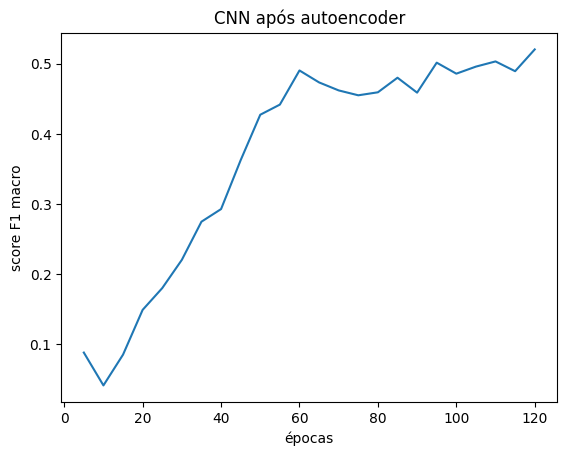

In [ ]:
gc.collect()
plt.plot(ep,score_autoenc)

plt.xlabel("épocas")
plt.ylabel("score F1 macro")
plt.title("CNN após autoencoder")

###Testando o Modelo

Para checar o quão bem a CNN com Autoencoder aprendeu a tarefa, utilizamos ela para prever o grupo de teste, e geramos o Classification Report.

Podemos ver que o Score F1 Macro é por volta de 0,51.

In [ ]:
pred_cnn_ae = model_cnn_ae.predict(enc.predict(np.array(test_dados)))

10/10 [==============================] - 0s 5ms/step


In [ ]:
print(classification_report(labels_test,encoder.inverse_transform(np.argmax(pred_cnn_ae,axis=1))))

              precision    recall  f1-score   support

       blues       0.41      0.53      0.46        30
   classical       0.71      0.67      0.69        33
     country       0.28      0.46      0.35        28
       disco       0.42      0.30      0.35        27
      hiphop       0.67      0.56      0.61        25
        jazz       0.46      0.67      0.55        27
       metal       0.73      0.75      0.74        36
         pop       0.71      0.50      0.59        30
      reggae       0.59      0.49      0.53        35
        rock       0.44      0.28      0.34        29

    accuracy                           0.53       300
   macro avg       0.54      0.52      0.52       300
weighted avg       0.55      0.53      0.53       300

